In [40]:
import csv
import numpy as np
import pandas as pd
import gurobipy as gp
from gurobipy import GRB
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import gurobipy as gp
from gurobipy import GRB
from scipy.optimize import minimize
import matplotlib.dates as mdates
from datetime import datetime
import os


# Partie A 
def importClean_Ind(csv_file_path, desired_returns):
    """
    Cette fonction importe des données à partir d'un fichier CSV spécifié, effectue un nettoyage de données,
    et retourne un DataFrame contenant des données filtrées.

    Args:
        csv_file_path(str): Chemin vers le fichier CSV avec les données brutes.

    Return:
        DataFrame: DataFrame contenant les données historiques filtrées pour les 10 industries, 
        pour les 48 industries et certains facteurs de Fama-French.
    """


    # Importation
    with open(csv_file_path, 'r', newline='') as file:
        reader = csv.reader(file)
        
        # Sauter les 10 premières lignes
        for _ in range(10):
            next(reader)

        # Lire le reste du fichier CSV dans un DataFrame
        df = pd.DataFrame(reader)
        df.columns = df.iloc[1]
        df = df.drop(df.index[1])
        df = df.reset_index(drop=True)

    # Nettoyage
    df = df.rename(columns={df.columns[0]: 'Date'})
    first_row = df[df.iloc[:, 0].str.strip() == desired_returns].index
    
    # Si 'desired_returns' est 'Number of Firms in Portfolios' ou 'Average Firm Size', 
    # alors sauter une ligne supplémentaire pour accéder aux données dans le bon format
    if desired_returns in ['Number of Firms in Portfolios', 'Average Firm Size', 'Sum of BE / Sum of ME']:
        df_AEWR_monthly = df.iloc[first_row.values[0] + 2:].reset_index(drop=True)
    else:
        df_AEWR_monthly = df.iloc[first_row.values[0] + 1:].reset_index(drop=True)
        
    last_row = (df_AEWR_monthly['Date'].str.len() != 6).idxmax()
    df_AEWR_monthly = df_AEWR_monthly.iloc[:last_row]
    
    # Adapter le format de la date en fonction de 'desired_returns'
    # Condition spécifique pour le facteur BtoM (Book-to-Market)
    if desired_returns in ['Sum of BE / Sum of ME']:  
        df_AEWR_monthly['Date'] = df_AEWR_monthly['Date'].str.strip()
        df_AEWR_monthly['Date'] = pd.to_datetime(df_AEWR_monthly['Date'], format='%Y')
    else:
        df_AEWR_monthly['Date'] = pd.to_datetime(df_AEWR_monthly['Date'], format='%Y%m')
    
    df_AEWR_monthly.iloc[:, 1:] = df_AEWR_monthly.iloc[:, 1:].astype(float)

    # Vérifier si le nom du fichier contient '48_Industry_Portfolios.CSV',
    # pour appliquer un nettoyage supplémentaire pour les NaN values
    if '48_Industry_Portfolios.CSV' in os.path.basename(csv_file_path):
        df_AEWR_monthly.replace(-99.99, np.nan, inplace=True)
        df_AEWR_monthly.replace(-999, np.nan, inplace=True)
        df_AEWR_monthly.dropna(inplace=True)
        
    # Retourner le DataFrame et fixer la 'Date' comme index  
    df = df_AEWR_monthly.set_index('Date', drop=True)
    
    return df


def importClean_rf(csv_file_path):
    """
    Cette fonction importe des données à partir du fichier CSV des 3 facteurs Fama-French, puis effectue un nettoyage de données
    et retourne un DataFrame contenant des données filtrées spécifiquement pour les taux sans risque dans la colonne 'RF'.

    Args:
        csv_file_path (str): Chemin vers le fichier CSV avec les données brutes.

    Return:
        DataFrame: DataFrame contenant les données nettoyées pour les taux sans risque.
    """
    
    
    # Importation des données en sautant les 3 premières lignes
    df = pd.read_csv(csv_file_path, skiprows=3)  

    # Renommage des colonnes pour faciliter la manipulation
    df.columns = ['Date', 'Mkt-RF', 'SMB', 'HML', 'RF']

    # Suppression des lignes dont la date ne correspond pas au format '%Y%m'
    df = df[df['Date'].str.match(r'^\d{6}$', na=False)]

    # Conversion de 'Date' en datetime
    df['Date'] = pd.to_datetime(df['Date'], format='%Y%m')

    # Conversion de 'RF' en float
    df['RF'] = df['RF'].astype(float)
    
    # Filtrage des colonnes 
    df = df[['Date', 'RF']] 
    
    # Mise en index de la colonne 'Date'
    df.set_index('Date', inplace=True)
    
    return df


def max_sharpe(z_bar, Sigma, Rf, short_allowed = False):
    """
    Calcul les poids optimisés des actifs dans le portefeuille qui maximisent le ratio de Sharpe avec et sans contrainte de vente à découvert,
    en utilisant le solveur de programmation linéaire GUROBI dans le cas avec contrainte sur vente à découverte et analytiquement pour le cas 
    sans contrainte de vente à découvert.

    Parameters:
    - z_bar (Series): Les rendements attendus de chacun des actifs.
    - Sigma (DataFrame): La matrice de covariance des rendements des actifs.
    - Rf (float): Le taux de rendement sans risque mensuel.
    - short_allowed (bool): Autorise ou non les positions courtes dans le portefeuille.

    Return:
    - weights_df (pd.DataFrame): Un dataFrame contenant les poids optimaux de chaque actif dans le portefeuille qui maximise le ratio de sharpe.
    """
    
    
    # Identifier les actifs et leur nombre
    assets = z_bar.index
    number_of_assets = len(assets)

    if short_allowed == False:
        # Initialiser le modèle d'optimisation
        model = gp.Model("max_sharpe")
        
        # Désactiver l'affichage de la console
        model.Params.LogToConsole = 0
        model.Params.OutputFlag = 0

        # Définir les variables de décision: les poids y et la variable auxiliaire kappa
        if short_allowed :
            y = model.addVars(assets, lb=-100.0, name='weights')
        else:
            y = model.addVars(assets, lb=0, name='weights')
        
        kappa = model.addVar(lb=0.0, name='kappa')
        
        # Construire le vecteur des poids y
        y_vector = [y[i] for i in assets]

        # Calculer la variance du portefeuille (sigma_p) en fonction des poids y et de la matrice de covariance Sigma
        sigma_p = sum(y_vector[i] * y_vector[j] * Sigma.loc[assets[i], assets[j]]
                        for i in range(number_of_assets) for j in range(number_of_assets))
        
        # Ajouter des contraintes au modèle d'optimisation
        model.addConstr(sum((z_bar[i] - Rf) * y[i] for i in assets) == 1, "Rendement ajusté") # Contrainte de rendement ajusté normalisé selon k
        model.addConstr(sum(y[i] for i in assets) == kappa) # Constrainte nécessaire pour que kappa ne soit pas nul
        
        # Définir l'objectif: Minimiser la variance du portefeuille (Maximiser le ratio de Sharpe)
        model.setObjective(sigma_p, GRB.MINIMIZE)
        
        # Exécuter l'optimisation
        model.optimize()
        
        # Vérifier si la solution optimale a été trouvée
        if model.status == GRB.OPTIMAL:
            y_opt = model.getAttr('x', y) # Poids optimaux y
            kappa_opt = kappa.X # Valeur optimale de kappa
            
            # Calculer et ajuster les poids du portefeuille original x à partir de y et kappa
            x_opt = {i: y_opt[i] / (kappa_opt) for i in assets}
            
            # Convertir les poids en DataFrame
            weights_df = pd.DataFrame([x_opt], columns=assets)
            
            return weights_df
        else:
            print("Optimization non réussie. Impossible de retrouver la solution à cette date précise.")
            return None
    else:
        # Utiliser la formule analytique pour les poids du portefeuille tangent (qui maximise le ratio de Sharpe)
        one = np.ones(number_of_assets)
        A = np.dot(one, np.dot(np.linalg.inv(Sigma), one.T))
        B = np.dot(one, np.dot(np.linalg.inv(Sigma), z_bar))
        w = (np.dot(np.linalg.inv(Sigma), z_bar - Rf*np.ones(number_of_assets))/(B - A*Rf)).tolist()

        # Convertir les poids en DataFrame
        weights = {n: w[i] for i, n in enumerate(assets)}
        weights_df = pd.DataFrame([weights], columns=assets)

        return weights_df


def Inverse_Variance_Portfolio(Sigma):
    """
    Calcule le portefeuille où les poids des actifs sont inversement proportionnels à la variance de l'actif.
    
    Parameters:
    - Sigma (Dataframe): La matrice de covariance des rendements des actifs. 
    
    Return:
    - normalized_weights (DataFrame): Un dataFrame contenant les poids optimaux (inversement reliés à la variance) de chaque actif dans le portefeuille.
    """
    
    
    # Extraire les variances de la diagonale de la matrice de covariance Sigma 
    variances = Sigma.values.diagonal()
    
    # Calculer l'inverse de chaque variance
    # Objectif : donner plus de poids aux actifs ayant une plus faible variance
    inverse_variance_weights = 1 / variances
    
    # Normaliser les poids inverses de la variance pour qu'ils somment à 1
    normalized_weights_var = inverse_variance_weights / inverse_variance_weights.sum()
    
    # Convertir le tableau numpy de poids normalisés en un DataFrame pandas
    normalized_weights_var = pd.DataFrame([normalized_weights_var], columns=Sigma.index)
    
    # Retourner le DataFrame des poids normalisés 
    return normalized_weights_var


def Inverse_Volatility_Portfolio(Sigma):
    """
    Calcule les poids du portefeuille qui sont inversement proportionnels à la volatilité de chaque actif.
    
    Parameters:
    - Sigma (Dataframe):  DataFrame Pandas représentant la matrice de covariance des rendements des actifs. 
    
    Return:
    - normalized_weights_std (Dataframe): Un dataFrame contenant les poids optimaux (inversement reliés à la volatilité) de chaque actif dans le portefeuille.
    """
    
    
    # Calcule la volatilité (écart type de la variance) pour chaque actif
    volatilites = np.sqrt(Sigma.values.diagonal())

    # Calcule l'inverse de la volatilité pour chaque actif
    # Objectif : donner plus de poids aux actifs moins volatils (c'est-à-dire ceux ayant une faible volatilité)
    inverse_volatility_weights = 1 / volatilites

    # Normaliser les poids inverses de la volatilité pour qu'ils somment à 1
    normalized_weights_std = inverse_volatility_weights / inverse_volatility_weights.sum()

    # Convertir le tableau numpy de poids normalisés en un DataFrame pandas
    normalized_weights_std = pd.DataFrame([normalized_weights_std], columns=Sigma.index)

    # Retourner le DataFrame des poids normalisés
    return normalized_weights_std


def Equally_Weighted_Portfolio(assets):
    """
    Calcule les poids équipondérés (1/N) pour chaque actif dans le portefeuille de 10 industries.
    
    Parameters:
    - Assets: DataFrame Pandas représentant le nombre d'actifs dans le portefeuille.
    
    Return:
    - portfolio_weights (Dataframe) : Un dataFrame contenant des poids égaux pour chaque actif dans le portefeuille 1/N.
    """
    
    
    # Nombre d'actifs dans le portefeuille d'industries
    n_assets = len(assets) 
    
    # Poids équipondérés dans le portefeuille (1/N pour chaque actif)
    equal_weight = 1 / n_assets 
    
    # Créer un dictionnaire de poids pour chaque actif
    EW_portfolio_weights = {asset: equal_weight for asset in assets}
    
    # Convertir le dictionnaire de poids en un DataFrame pandas
    EW_portfolio_weights = pd.DataFrame([EW_portfolio_weights], columns=assets)
    
    return EW_portfolio_weights


def Market_Cap_Weighted_Portfolio(df_average_firm_size, df_number_firm):
    """
    Cette fonction calcule les poids proportionnels à la capitalisation boursière pour chaque actifs dans le portefeuille d'industries,
    étant donné la taille moyenne des entreprises et le nombre d'entreprises.
    
    Parameters:
    - df_average_firm_size: DataFrame représentant la taille moyenne de l'entreprise pour chaque actif dans le portefeuille au fil du temps.
    - df_number_firm: DataFrame représentant le nombre d'entreprises pour chaque actif dans le portefeuille au fil du temps.
    
    Returns:
    - weights: DataFrame contenant les poids selon la capitalisation boursière pour chaque actif dans le portefeuille.
    """
    
    
    # Calcule la capitalisation boursière pour chaque actif dans le portefeuille au fil du temps
    market_caps = df_average_firm_size.multiply(df_number_firm)
    
    # Calcule la capitalisation boursière totale pour tous les actifs pour chaque date
    total_market_cap = market_caps.sum(axis=1)
    
    # Calcule les poids pour chaque actif en divisant la capitalisation boursière de chaque actif par la capitalisation boursière totale
    VW_portfolio_weights = market_caps.div(total_market_cap, axis='index')
    
    # Retourne les poids du portefeuille optimal dans un DataFrame 
    VW_portfolio_weights = pd.DataFrame(VW_portfolio_weights, columns=df_average_firm_size.columns)
    
    return VW_portfolio_weights


def MV_optimize_portfolio(z_bar, Sigma, short_allowed=False):
    """
    Calcul les poids optimaux qui minimisent la variance du portefeuille avec une contrainte de budget dans les deux cas avec et sans contrainte de vente à découvert,
    en utilisant le solveur de programmation linéaire GUROBI.
    
    Parameters:
    - z_bar (Series): Série pandas contenant les rendements attendus pour chaque actif du portefeuille d'industrie.
    - Sigma (DataFrame): DataFrame pandas représentant la matrice de covariance des rendements des actifs du portefeuille. 
    - short_allowed (bool): Booléen indiquant si les positions de ventes à découvert sont autorisées (True) ou non autorisées (False).

    Return:
    - df_results (pd.DataFrame): Un DataFrame pandas contenant les poids optimaux pour chaque actif (optimal_w) si l'optimisation a convergé vers une solution.
    """
    
    
    # Récupérer les actifs et le retour cible
    assets = z_bar.index
    # mu_target = 0.02  

    # Création d'un nouveau modèle d'optimisation linéaire
    m = gp.Model("MV_portfolio")

    # Création de variables pour les poids de chaque actif dans le portefeuille
    if short_allowed:
        weights = m.addVars(assets, lb=-GRB.INFINITY, name="weights")
    else:
        weights = m.addVars(assets, lb=0, ub=1, name="weights")

    # Variance du portefeuille (objectif à minimiser) : w^T * Sigma * w 
    portfolio_variance = sum(weights[i] * Sigma.loc[i, j] * weights[j] for i in assets for j in assets)

    # Définir l'objectif pour minimiser la variance du portefeuille 
    m.setObjective(portfolio_variance, GRB.MINIMIZE)

    # Ajouter des contraintes pour le budget et le retour cible
    m.addConstr(sum(weights[asset] for asset in assets) == 1, "budget")
    # m.addConstr(sum(weights[asset] * z_bar[asset] for asset in assets) >= mu_target, "target_return") # Contrainte optionnelle pour le retour cible 

    # Optimiser le modèle 
    m.Params.LogToConsole = 0
    m.optimize()

    # Vérifier si l'optimisation a été réussie 
    if m.status == GRB.OPTIMAL:
        
        # Obtenir les poids optimaux et la variance si l'optimisation est réussie 
        optimal_w = {asset: weights[asset].X for asset in assets}

        # Créer un DataFrame pour les résultats optimaux
        df_results = pd.DataFrame(optimal_w, index=[0])
    else:
        print("Optimization was unsuccessful. Unable to retrieve the solution.")
        return None
    
    return df_results


def MV_portfolio(z_bar, Sigma):
    """
    Calcul les poids optimaux qui minimisent la variance du portefeuille sans contrainte de vente à découvert,
    en utilisant la formule analytique.

    Parameters:
    - z_bar (Series): Série pandas contenant les rendements attendus pour chaque actif du portefeuille d'industrie.
    - Sigma (DataFrame): DataFrame pandas représentant la matrice de covariance des rendements des actifs du portefeuille.

    Returns:
    - df_results (pd.DataFrame): Un DataFrame pandas contenant les poids optimaux pour chaque actif.
    """


    # Récupérer les actifs et leur nombre
    assets = z_bar.index
    number_of_assets = len(assets)

    # Appliquer la formule
    one = np.ones(number_of_assets)
    lambd = 1/(np.dot(one, np.dot(np.linalg.inv(Sigma), one.T)))
    w = lambd*np.dot(np.linalg.inv(Sigma), one.T).T

    # Convertir les poids en DataFrame
    weights = {n: w[i] for i, n in enumerate(assets)}
    weights_df = pd.DataFrame([weights], columns=assets)

    return weights_df


def rolling_window_optimization(df,df_rf, df_average_firm_size, df_number_firm, window_size, optimization_type):
    """
    Calculate portfolio weights for each window using a rolling window based on the specified optimization type.

    Parameters:
    - df (DataFrame): DataFrame containing asset returns for each month with dates as index.
    - df_rf (DataFrame): DataFrame containing risk-free rate for each month with dates as index.
    - df_average_firm_size (DataFrame): DataFrame containing average firm size for each month with dates as index.
    - df_number_firm (DataFrame): DataFrame containing number of firms for each month with dates as index.
    - window_size (int): Size of the rolling window in months.
    - optimization_type (str): Type of portfolio optimization to perform ('min_variance' for minimum variance portfolio, or other types as needed).

    Return:
    - results_df (DataFrame): DataFrame containing portfolio weights (weights_df) for each rolling window with associated dates as the index (In-sample weights).
    """   

    
    results = []
    dates = []
    weights_df = None
    
    
    # Itérer sur chaque fenêtre de la taille spécifiée
    for start_idx in range(len(df) - window_size + 1): 
        window_data = df.iloc[start_idx:start_idx + window_size] # Récupère les rendements pour la fenêtre actuelle
        end = start_idx + window_size # Calcule l'indice de fin de la fenêtre roulante en cours

        # Récupère le taux sans risque moyen pour la fenêtre roulante en cours 
        window_rf = df_rf.iloc[start_idx:end]['RF'].mean()

        window_average_firm_size = df_average_firm_size.iloc[start_idx:start_idx + window_size] # Récupère les tailles moyennes des entreprises pour la fenêtre actuelle
        window_number_firm = df_number_firm.iloc[start_idx:start_idx + window_size] # Récupère le nombre d'entreprises pour la fenêtre actuelle 
        
        # Calcul de la matrice de covariance et du rendement attendu pour la fenêtre actuelle 
        Sigma = window_data.cov()
        z_bar = window_data.mean()

        # Appel des sept fonctions d'optimisation de portefeuille
        # Call the minimum variance portfolio optimization function with short selling allowed
        if optimization_type == 'min_variance_short_allowed':
            weights_df = MV_portfolio(z_bar, Sigma)
            
        # Call the maximum sharpe ratio portfolio optimization function with short selling not allowed
        elif optimization_type == 'max_sharpe_no_short':
            weights_df = max_sharpe(z_bar, Sigma, window_rf, short_allowed= False)
            
        # Call the maximum sharpe ratio portfolio optimization function with short selling allowed
        elif optimization_type == 'max_sharpe_short_allowed':
            weights_df = max_sharpe(z_bar, Sigma, window_rf, short_allowed= True)
            
        # Call the inverse variance portfolio optimization function
        elif optimization_type == 'inv_variance_weights':
            weights_df = Inverse_Variance_Portfolio(Sigma)
        
        # Call the inverse volatility portfolio optimization function
        elif optimization_type == 'inv_volatility_weights':
            weights_df = Inverse_Volatility_Portfolio(Sigma)
        
        # Call the equally weighted portfolio optimization function
        elif optimization_type == 'equal_weights':
            weights_df = Equally_Weighted_Portfolio(df.columns)
        
        # Call the market cap weighted portfolio optimization function    
        elif optimization_type == 'market_cap_weights':
            weights_df = Market_Cap_Weighted_Portfolio(window_average_firm_size, window_number_firm)
            
        # Vérifie si l'optimisation a retourné des résultats 
        if weights_df is not None:  
            
            # Récupération des poids pour l'optimisation market_cap_weights puisque les poids sont stockés dans un DataFrame 
            if isinstance(weights_df.index, pd.DatetimeIndex):
                weights = weights_df.iloc[-1, :].tolist()
            else:
                weights = weights_df.loc[0, df.columns].tolist() # Récupère les poids optimaux pour la fenêtre actuelle
            results.append(weights) 

            dates.append(window_data.index[-1]) # Utilisation de l'index pour la date de fin de la fenêtre
        # Si l'optimisation a échoué, affiche un message d'erreur
        else:
            print(f"Optimization failed for the window ending on {window_data.index[-1]}")

            
    # Création du DataFrame des résultats
    results_df = pd.DataFrame(results, index=dates, columns=df.columns)
    return results_df


def Out_of_sample_portfolio_returns(results_df, df):
    """
    Calculate the monthly out-of-sample returns of the portfolios using the optimized in-sample weights.
    
    Parameters:
    - results_df (DataFrame): DataFrame containing portfolio weights (weights_df) for each rolling window with associated dates as the index (In-sample weights).
    - df (DataFrame): DataFrame containing asset returns for each month with dates as the index (used to calculate the portfolio returns).
    
    Return:
    - DataFrame: The same 'results_df' DataFrame containing optimized in-sample weights with an additional column 'Portfolio Monthly Return' containing the calculated returns for the optimized portfolios (out-of-sample returns).
    """
    
    
    portfolio_monthly_returns = []
    
    # Itére sur chaque ligne de 'results_df' pour accéder aux poids optimisés de chaque fenêtre
    for index, row in results_df.iterrows():
        next_month = index + pd.DateOffset(months=1) # Calcule la date correspondant au mois suivant la fin de la fenêtre roulante
        if next_month in df.index:
            next_month_returns = df.loc[next_month]  # Extrait les rendements des actifs pour le mois suivant
            weights = row.values # Extrait les poids optimisés du portefeuille pour la fenêtre actuelle
            portfolio_return = np.dot(weights, next_month_returns) # Calcule le rendement du portefeuille pour le mois suivant
            portfolio_monthly_returns.append(portfolio_return) # Ajouter le rendement calculé du portefeuille à la liste des rendements mensuels
        else:
            portfolio_monthly_returns.append(None)
    
    # Ajouter la liste des rendements mensuels calculés à 'results_df' comme nouvelle colonne
    results_df['Portfolio Monthly Return'] = portfolio_monthly_returns
    return results_df


def plot_cumulative_returns(df, strategies, df_rf, df_average_firm_size, df_number_firm):
    """
    Cette fonction plot les rendements cumulatifs pour les 7 stratégies de portefeuilles d'industries. 

    Parameters:
    - df: DataFrame contenant les données de rendement.
    - strategies: Liste des stratégies à utiliser dans le tracé des rendements cumulatifs.
    
    Return : 
    - Plot des rendements cumulatifs pour les 7 stratégies de portefeuilles d'industries.
    """
    
    
    def cumulative_returns_calculation(mensual_returns, is_decimal=False):
        """
        Cette fonction calcule les retours cumulatifs à partir des séries temporelles de rendements mensuels pour les 7 stratégies de portefeuille.

        Parameters:
        - mensual_returns: Séries pandas contenant les retours mensuels du portefeuille sélectionné en décimal.
        
        Returns : 
        - cumulative_returns: Séries pandas contenant les retours cumulatifs du portefeuille sélectionné en décimal.
        """
        
        
        # Convertir les pourcentages en décimales et ajouter 1
        adjusted_returns = mensual_returns / 100 + 1 if not is_decimal else mensual_returns + 1

        # Calculer les retours cumulatifs avec la fonction cumprod() de pandas qui calcule le produit cumulatif des retours mensuels
        cumulative_returns = adjusted_returns.cumprod()

        return cumulative_returns

    # Initialiser le dictionnaire pour stocker les résultats de chaque stratégie de portefeuille 
    results_dict = {}

    # Boucle sur chaque stratégie de portefeuille 
    for strategy in strategies:
        # Appeler la fonction d'optimisation pour chaque stratégie et calculer les rendements du portefeuille sur la bonne fenêtre roulante d'optimisation
        results_df = Out_of_sample_portfolio_returns(rolling_window_optimization(df, df_rf, df_average_firm_size, df_number_firm, 60, optimization_type=strategy), df)
        
        # Stocker les résultats dans le dictionnaire 
        results_dict[strategy] = results_df

    # Boucle sur chaque stratégie de portefeuille pour tracer les rendements cumulatifs 
    for strategy in strategies:
        # Récupérer les rendements de la stratégie
        results_with_returns = results_dict[strategy]
        
        # Supprimer les valeurs manquantes dans les rendements mensuels pour la dernière date 2024-01-01
        results_with_returns['Portfolio Monthly Return'].dropna(inplace=True)
        
        # Calculer les rendements cumulatifs
        results_with_returns['Cumulative Return'] = cumulative_returns_calculation(results_with_returns['Portfolio Monthly Return'])

        # Tracer les rendements cumulatifs pour chaque stratégie
        plt.plot(results_with_returns.index, results_with_returns['Cumulative Return'], label=strategy)

    plt.title('Rendements cumulatifs des stratégies de portefeuilles (hors échantillon)')
    plt.xlabel('Date')
    plt.ylabel('Rendements cumulatifs (%)')  
    plt.legend()
    plt.show()
    
    
def format_value(val):
    """
    Cette fonction formate les valeurs numériques pour l'affichage, en utilisant un format de chaîne de caractères spécifié.
    
    Paramètres :
    - val (float) : Valeur numérique à formater.
    """
    
    
    return "{:.4f}".format(val)


def annualized_statistics_and_sharpe_ratios(strategies_results, periods, df_rf, is_decimal=False):
    """
    Calcule les statistiques annualisées pour les rendements hors échantillon de différentes stratégies de portefeuille sur des périodes spécifiées,
    et détermine les ratios de Sharpe annuels pour ces stratégies.

    Parameters:
    - strategies_results (dict) : Dictionnaire de DataFrames, où chaque clé représente le nom d'une stratégie et chaque valeur est
    un DataFrame contenant les résultats pour les poids optimaux de cette stratégie, y compris les 'Rendements Mensuels du Portefeuille'.
    - periods (liste de tuples) : Liste de tuples contenant la date de début et la date de fin d'une période à analyser,
    au format ('AAAA-MM-JJ', 'AAAA-MM-JJ').
    - df_rf (DataFrame) : DataFrame contenant les taux sans risque mensuels.
    - is_decimal (bool) : Booléen indiquant si les rendements sont en pourcentage (False) ou en décimal (True) pour le calcul.

    Return:
    - DataFrame contenant la moyenne annualisée et l'écart-type annualisé des rendements mensuels du portefeuille, ainsi que les ratios de Sharpe
    pour chaque stratégie et chaque période spécifiée.
    """
    
    
    results = []

    # Calculer le taux sans risque mensuel moyen et l'annualiser selon la formule du taux de rendement annuel composé (CAGR), 
    # pour obtenir le taux sans risque annuel moyen
    mean_rf_monthly = df_rf['RF'].mean()
    mean_rf_annual = ((1 + mean_rf_monthly/100) ** 12 - 1) 
    
    # Convertir en pourcentage pour faciliter les manipulations par la suite
    mean_rf_annual *= 100

    for strategy_name, strategy_results in strategies_results.items():
        for start_date, end_date in periods:
            # Filtrer les résultats de la stratégie pour la période spécifiée
            period_returns = strategy_results['Portfolio Monthly Return'].loc[start_date:end_date]

            # Calculer la moyenne et l'écart-type des rendements mensuels du portefeuille pour la période indiquée
            mean_return_monthly = period_returns.mean()
            std_return_monthly = period_returns.std()

            # Annualiser la moyenne et l'écart-type des rendements mensuels, avec la formule du taux de rendement annuel composé (CAGR)
            mean_return_annualized = (1 + mean_return_monthly/100) ** 12 - 1 if not is_decimal else (1 + mean_return_monthly) ** 12 - 1
            std_return_annualized = std_return_monthly * np.sqrt(12) if not is_decimal else std_return_monthly * np.sqrt(12) * 100
            
            # Convertir en pourcentage pour faciliter les manipulations par la suite
            mean_return_annualized = mean_return_annualized * 100 

            # Calculer le ratio de Sharpe annuel pour chaque stratégie et période
            sharpe_ratio = (mean_return_annualized - mean_rf_annual) / std_return_annualized

            # Appliquer le formatage adapté à la valeur du ratio de Sharpe
            formatted_mean_return = format_value(mean_return_annualized)
            formatted_std_deviation = format_value(std_return_annualized)
            formatted_sharpe_ratio = format_value(sharpe_ratio)

            # Ajouter les résultats à la liste
            results.append({
                'Strategy': strategy_name,
                'Start Date': start_date,
                'End Date': end_date,
                'Annualized Mean Return': formatted_mean_return,
                'Annualized Std Deviation': formatted_std_deviation,
                'Sharpe Ratio': formatted_sharpe_ratio
            })

    # Créer un DataFrame à partir de la liste des résultats
    results_df = pd.DataFrame(results)

    # Définir les noms des stratégies et les périodes comme index du DataFrame
    results_df.index = pd.MultiIndex.from_frame(results_df[['Strategy', 'Start Date', 'End Date']])
    results_df = results_df.drop(columns=['Strategy', 'Start Date', 'End Date'])

    return results_df



# Partie B
def import_and_prepare_daily_data(csv_file_path):
    """
    Importe et prépare les données quotidiennes à partir d'un fichier CSV spécifié pour les 48 Industries 
    du portefeuille.

    Args:
    - csv_file_path (str): Le chemin complet vers le fichier CSV contenant les données quotidiennes 
    des rendements des 48 Industries.

    Return:
    - pd.DataFrame: Un DataFrame contenant les données quotidiennes nettoyées et préparées 
        pour les 48 Industries du portefeuille, avec les dates en index.
    """


    # Lecture du fichier CSV, avec l'en-tête à la ligne 6 (index 5)
    df_daily = pd.read_csv(csv_file_path, header=5)

    # Renommage de la première colonne pour indiquer qu'elle contient les dates
    df_daily = df_daily.rename(columns={'Unnamed: 0': 'Date'})

    # Copie et préparation des données jusqu'à la ligne spécifiée (25670)
    df_daily_ret = df_daily.iloc[:25670].copy()
    df_daily_ret['Date'] = pd.to_datetime(df_daily_ret['Date'], format='%Y%m%d')
    df_daily_ret.set_index('Date', inplace=True)
    df_daily_ret = df_daily_ret.apply(pd.to_numeric, errors='coerce')
    df_daily_ret.replace(-99.99, np.nan, inplace=True)
    df_daily_ret.replace(-999, np.nan, inplace=True)
    df_daily_ret.dropna(inplace=True)

    # Sélection d'un sous-ensemble des données à partir de la ligne spécifiée (232)
    df_daily_ret = df_daily_ret.iloc[231:].copy()

    return df_daily_ret


def import_and_clean_FF_3factors_daily(csv_file_path, df_reference):
    """
    Importe et nettoie les données des 3 quotidiennes des 3 facteurs Fama-French.

    Args:
    - csv_file_path (str): Chemin vers le fichier CSV contenant les données quotidiennes des facteurs Fama-French.
    - df_reference (pd.DataFrame): DataFrame de référence pour aligner les indices de dates, (df_daily_ret) dans cet exemple.

    Return:
        pd.DataFrame: DataFrame contenant les données quotidiennes des 3 facteurs Fama-French nettoyées et alignées.
    """


    # Lecture du fichier CSV, en supposant que l'en-tête se trouve à la 4ème ligne (index 3)
    df_FF = pd.read_csv(csv_file_path, header=3)

    # Renommage de la première colonne pour indiquer qu'elle contient les dates
    df_FF = df_FF.rename(columns={'Unnamed: 0': 'Date'})

    # Sélection des données jusqu'à la ligne spécifiée (25670 dans cet exemple)
    df_FF_daily = df_FF.iloc[:25670].copy()

    # Conversion de la colonne 'Date' au format datetime
    df_FF_daily['Date'] = pd.to_datetime(df_FF_daily['Date'], format='%Y%m%d')

    # Définition de la colonne 'Date' comme index du DataFrame
    df_FF_daily.set_index('Date', inplace=True)

    # Conversion des données en numérique, gestion des erreurs par coercition à NaN
    df_FF_daily = df_FF_daily.apply(pd.to_numeric, errors='coerce')

    # Remplacement des valeurs erronées ou manquantes spécifiques par NaN
    df_FF_daily.replace(-99.99, np.nan, inplace=True)
    df_FF_daily.replace(-999, np.nan, inplace=True)

    # Suppression des lignes contenant des NaN pour assurer la complétude des données
    df_FF_daily.dropna(inplace=True)

    # Alignement du DataFrame des facteurs Fama-French avec l'index du DataFrame de référence
    df_FF_daily_aligned = df_FF_daily.reindex(df_reference.index)

    return df_FF_daily_aligned


def import_FF_5factors_monthly(csv_file_path, df_reference):
    """
    Importe et prépare les données des 5 facteurs de Fama-French à partir d'un fichier CSV contenant les facteurs mensuels.

    Args:
    - csv_file_path (str): Le chemin complet vers le fichier CSV contenant les données des 5 facteurs de Fama-French.
    - df_reference (pd.DataFrame): DataFrame momemtum utilisé pour "locker" les données des 5 facteurs sur la base des dates de ce DataFrame.

    Returns:
        pd.DataFrame: DataFrame contenant les données des 5 facteurs de Fama-French nettoyées et préparées. 
    """


    # Lecture du fichier CSV, l'en-tête se trouve à la 2ème ligne (index 1)
    df_FF = pd.read_csv(csv_file_path, header=2)

    # Renommage de la première colonne 
    df_FF = df_FF.rename(columns={'Unnamed: 0': 'Date'})

    # Sélection des données pertinentes jusqu'à la ligne spécifiée (727)
    df_FF = df_FF.iloc[:727].copy()

    # Conversion de la colonne 'Date' en format datetime 
    df_FF['Date'] = pd.to_datetime(df_FF['Date'], format='%Y%m')

    # Définition de la colonne 'Date' comme index du DataFrame 
    df_FF.set_index('Date', inplace=True)

    # Conversion des valeurs du DataFrame en numérique, 
    # avec gestion des erreurs pour les valeurs non numériques
    df_FF = df_FF.apply(pd.to_numeric, errors='coerce')

    # Filtrage des données pour ne conserver que les dates présentes dans df_reference
    df_FF = df_FF.loc[df_reference.index]

    return df_FF



def calculate_betas(start_date, end_date, df_daily_ret_reshaped, df_FF_daily):
    # Sélectionner les données pour la plage de dates spécifiée
    df_daily_ret_selected = df_daily_ret_reshaped.loc[start_date:end_date]
    df_FF_daily_selected = df_FF_daily.loc[start_date:end_date]

    # Maintenant, vous pouvez utiliser df_daily_ret_selected et df_FF_daily_selected pour votre régression
    Rft = df_FF_daily_selected['RF']
    Rm_t = df_FF_daily_selected['Mkt-RF']

    betas = []  # Create an empty list to store the betas

    for column in df_daily_ret_selected.columns:
        Ri_t = df_daily_ret_selected[column]

        Y = Ri_t - Rft
        X = Rm_t

        X = sm.add_constant(X)

        model = sm.OLS(Y, X)
        results = model.fit()

        betas.append(results.params[1])  # Add the betas to the list

    # Convert the list of betas to a numpy array
    betas = np.array(betas)

    return betas


def calculate_monthly_betas(df_daily_ret, df_FF_daily, df_48ind):
    """
    Calcule les betas mensuels pour chaque mois à partir des données quotidiennes des rendements des 48 industries du portefeuille, 
    des facteurs Fama-French quotidiens et des 48 industries.

    Args:
    - df_daily_ret (pd.DataFrame): DataFrame contenant les rendements quotidiens.
    - df_FF_daily (pd.DataFrame): DataFrame contenant les facteurs quotidiens de Fama-French.
    - df_48ind (pd.DataFrame): DataFrame contenant des données pour les 48 industries, utilisé pour définir les indices et les noms des colonnes du résultat final.

    Returns:
    - pd.DataFrame: DataFrame contenant les betas mensuels pour chaque mois, avec les dates comme index et les industries comme colonnes.
    """
    
    
    # Obtenir la première et la dernière date dans les données
    first_date = df_daily_ret.index.min()
    last_date = df_daily_ret.index.max()

    # Créer une plage de dates pour chaque mois dans les données
    date_range = pd.date_range(start=first_date, end=last_date, freq='M')

    # Calculer les betas pour chaque mois
    monthly_betas = {}
    for date in date_range:
        start_date = date - pd.DateOffset(months=12)
        end_date = date
        betas = calculate_betas(start_date, end_date, df_daily_ret, df_FF_daily)  # Assurez-vous que la fonction `calculate_betas` est définie
        monthly_betas[date] = betas

    # Convertir le dictionnaire en DataFrame
    df_monthly_betas = pd.DataFrame(monthly_betas.items(), columns=['Date', 'Betas'])

    # Convertir la colonne 'Betas' de tableaux numpy en listes
    df_monthly_betas['Betas'] = df_monthly_betas['Betas'].apply(list)

    # Définir la colonne 'Date' comme index
    df_monthly_betas.set_index('Date', inplace=True)

    # Convertir chaque élément de la liste 'Betas' en une colonne distincte
    df_monthly_betas = df_monthly_betas['Betas'].apply(pd.Series)

    # Faire correspondre l'index de df_monthly_betas à df_48ind
    df_monthly_betas.index = df_48ind.index

    # Faire correspondre les noms des colonnes de df_monthly_betas à df_48ind
    df_monthly_betas.columns = df_48ind.columns

    return df_monthly_betas


def calculate_idiosyncratic_volatility(start_date, end_date, df_daily_ret_reshaped, df_FF_daily):
    # Sélectionner les données pour la plage de dates spécifiée
    df_daily_ret_selected = df_daily_ret_reshaped.loc[start_date:end_date]
    df_FF_daily_selected = df_FF_daily.loc[start_date:end_date]

    # Maintenant, vous pouvez utiliser df_daily_ret_selected et df_FF_daily_selected pour votre régression
    Rft = df_FF_daily_selected['RF']
    Rm_t = df_FF_daily_selected['Mkt-RF']
    SMB = df_FF_daily_selected['SMB']
    HML = df_FF_daily_selected['HML']

    volatilities = []  # Create an empty list to store the volatilities

    for column in df_daily_ret_selected.columns:
        Ri_t = df_daily_ret_selected[column]

        Y = Ri_t - Rft
        X = pd.concat([Rm_t, SMB, HML], axis=1)

        X = sm.add_constant(X)

        model = sm.OLS(Y, X)
        results = model.fit()

        residuals = results.resid
        volatility = np.std(residuals)

        volatilities.append(volatility)  # Add the volatility to the list

    # Convert the list of volatilities to a numpy array
    volatilities = np.array(volatilities)

    return volatilities


def calculate_monthly_volatility(df_daily_ret, df_FF_daily_3factors_aligned, df_48Ind):
    """
    Calcule les volatilités idiosyncratiques mensuelles pour chaque mois à partir des données quotidiennes des rendements, 
    des facteurs Fama-French quotidiens alignés et des 48 industries.

    Args:
    - df_daily_ret_reshaped (pd.DataFrame): DataFrame contenant les rendements quotidiens reshaped.
    - df_daily_ret (pd.DataFrame): DataFrame contenant les rendements quotidiens.
    - df_FF_daily_3factors_aligned (pd.DataFrame): DataFrame contenant les facteurs quotidiens de Fama-French alignés.
    - df_48Ind (pd.DataFrame): DataFrame contenant des données pour les 48 industries.

    Returns:
    - pd.DataFrame: DataFrame contenant les volatilités idiosyncratiques mensuelles pour chaque mois, 
                    avec les dates comme index et les industries comme colonnes.
    """
    
    
    # Get the first and last date in the data
    first_date = df_daily_ret.index.min()
    last_date = df_daily_ret.index.max()

    # Create a date range for each month in the data
    date_range = pd.date_range(start=first_date, end=last_date, freq='M')

    # Calculate the volatilities for each month
    monthly_volatilities = {}
    for date in date_range:
        start_date = date - pd.DateOffset(months=1) + pd.DateOffset(days=1)
        end_date = date
        volatilities = calculate_idiosyncratic_volatility(start_date, end_date, df_daily_ret, df_FF_daily_3factors_aligned)
        monthly_volatilities[date] = volatilities

    # Convert the dictionary to a DataFrame
    df_monthly_vol = pd.DataFrame(monthly_volatilities.items(), columns=['Date', 'Betas'])

    # Convert the Betas column from numpy arrays to lists
    df_monthly_vol['Betas'] = df_monthly_vol['Betas'].apply(list)

    # Set the Date column as the index
    df_monthly_vol.set_index('Date', inplace=True)

    # Convert each item in the 'Betas' list to a separate column
    df_monthly_vol = df_monthly_vol['Betas'].apply(pd.Series)

    # Set the index of df_monthly_vol to match df_48Ind
    df_monthly_vol.index = df_48Ind.index

    # Set the column names of df_monthly_vol to match df_48Ind
    df_monthly_vol.columns = df_48Ind.columns

    return df_monthly_vol


def select_extreme_values(row, num_values=5):
    """
    Sélectionne les valeurs extrêmes dans une ligne (série) en fonction des valeurs triées dans l'ordre décroissant, 
    et retourne les premières valeurs les plus élevées et les dernières les plus basses, pour une caractéristique donnée.

    Args:
    - row (pd.Series): Une ligne (série) contenant les valeurs des caractéristiques à trier.
    - num_values (int, optional): Le nombre d'industries avec la caractéristique extrêmes à sélectionner. Fixé à 5 par défaut.

    Returns:
    - tuple: Un tuple contenant deux pandas Series, les premières "num_values" valeurs les plus élevées 
            et les dernières "num_values" valeurs les plus basses pour chaque caractéristique donnée.
    """
    
    
    # Triage dans l'ordre décroissant des caractéristiques (plus grande à plus petite) 
    sorted_row = row.sort_values(ascending=False)
    
    # Sélection des premières "num_values" valeurs les plus élevées
    top_values = sorted_row.head(num_values)
    
    # Sélection des dernières "num_values" valeurs les plus basses
    bottom_values = sorted_row.tail(num_values)
    
    return top_values, bottom_values


def get_returns(caracteristic, df_ret_shift, num_positions, weight_type='ew'):
    """
    Calcule les rendements totaux pour les positions longues et courtes basées sur les caractéristiques données, 
    les rendements des industries et le nombre de positions à prendre.

    Args:
    - caracteristic (pd.DataFrame): DataFrame contenant les caractéristiques de chaque industrie, 
                                    avec les dates en index et les industries en colonnes.
    - df_ret_shift (pd.DataFrame): DataFrame contenant les rendements des industries, avec un décalage de t+1 (shifted by 1), 
                                    pour calculer les rendements totaux pour les positions longues et courtes.
    - num_positions (int): Nombre de positions à prendre (par exemple, 5 industries extrêmes de chaque côté pour un total de 10 positions à chaque fois).
    - weight_type (str, optional): Type de pondération à utiliser, 'ew' pour équipondéré ou 'vw' pour pondération par capitalisation boursière (marketcap).
                                    Par défaut, 'ew', équipondéré.

    Returns:
    - list: Une liste contenant les rendements totaux pour les positions longues et courtes à la fin de chaque mois t+1. 
    """
    
    
    # Sélectionne les valeurs extrêmes pour chaque mois t 
    top_bottom_values = caracteristic.apply(select_extreme_values, axis=1)
    
    returns = []  # Initialise une liste pour stocker les rendements individuels pour chaque mois
    total_returns = []  # Initialise une liste pour stocker les rendements totaux pour chaque mois
    
    # Itération à travers toutes les valeurs extrêmes pour chaque mois 
    for date, values in top_bottom_values.items():
        top_indices, bottom_indices = values[0].index, values[1].index
        
        # Calcul des rendements pour les positions longues et courtes en fonction du type de pondération spécifié 
        if weight_type == 'ew':
            weight = 1.0 / num_positions  # Poids égal pour chaque position
            top_returns = df_ret_shift.loc[date, top_indices] * weight
            bottom_returns = df_ret_shift.loc[date, bottom_indices] * weight * -1  # Les positions courtes ont un poids négatif
        elif weight_type == 'vw':
            top_values = df_ret_shift.loc[date, top_indices]
            bottom_values = df_ret_shift.loc[date, bottom_indices]
            top_weights = top_values.abs() / top_values.abs().sum()  # Pondération par capitalisation boursière absolue 
            bottom_weights = bottom_values.abs() / bottom_values.abs().sum()  # Pondération par capitalisation boursière absolue 
            top_returns = top_values * top_weights 
            bottom_returns = bottom_values * bottom_weights * -1  # Les positions courtes ont un poids négatif 
        else:
            raise ValueError("weight_type must be either 'ew' or 'vw'")
        
        # Ajoute les rendements longs et courts à la liste des rendements
        returns.append((top_returns.sum(), bottom_returns.sum()))  
    
    # Calcule les rendements totaux pour chaque mois
    total_returns = [sum(x) for x in returns]  

    return total_returns


def get_sharpe_and_constants(caracteristic, df_ret_shift, num_positions, df_FF_daily_3factors_aligned, df_FF_5, weight_type='ew'):
    """
    Calcule le ratio de Sharpe et les constantes de régression (Alpha de Jensen) pour les rendements totaux des stratégies 'EW' et 'VW' en fonction des caractéristiques données,
    des rendements journaliers des 48 industries, du nombre de positions longues et courtes à prendre, du taux sans risque moyen annualisé selon la formule du (CAGR) et des 3, 4 et 5 facteurs de Fama-French.

    Args:
    - caracteristic (pd.DataFrame): DataFrame contenant les caractéristiques de chaque industrie, 
                                    avec les dates en index et les industries en colonnes.
    - df_ret_shift (pd.DataFrame): DataFrame contenant les rendements des industries, avec un décalage de t+1, 
                                    pour calculer les rendements totaux pour les positions longues et courtes.
    - num_positions (int): Nombre de positions à prendre (par exemple, 5 industries extrêmes de chaque côté pour un total de 10 positions à chaque fois).
    - rf (float): Taux sans risque mensuel moyen sur la période.
    - df_FF_5 (pd.DataFrame): DataFrame contenant les 5 facteurs de Fama-French, 
                                utilisés dans la régression pour calculer les constantes.
    - weight_type (str, optional): Type de pondération à utiliser, 'ew' pour équipondéré ou 'vw' pour pondération par capitalisation boursière.
                                    Par défaut, 'ew', équipondéré.

    Returns:
    - tuple: Un tuple contenant le ratio de Sharpe et les constantes de régression pour 3, 4 et 5 facteurs.
    """
    # Calculer le rendement annualisé du taux sans risque, selon la formule du taux de rendement annuel composé (CAGR)
    mean_rf_monthly = df_FF_daily_3factors_aligned['RF'].mean()
    mean_rf_annual = ((1 + mean_rf_monthly/100) ** 12 - 1)
    mean_rf_annual*=100

    # Obtenir les rendements totaux pour les positions longues et courtes 
    # en fonction du triage des caractéristiques et du type de pondération
    total_returns = get_returns(caracteristic, df_ret_shift, num_positions, weight_type)

    # Convertir la liste en pandas Series 
    total_returns_series = pd.Series(total_returns)
    
    # Calculer la moyenne et l'écart-type des rendements mensuels du portefeuille pour la période indiquée
    mean_return_monthly = total_returns_series.mean()
    std_return_monthly = total_returns_series.std()

    # Annualiser la moyenne et l'écart-type des rendements mensuels, avec la formule du taux de rendement annuel composé (CAGR)
    mean_return_annualized = (1 + mean_return_monthly/100) ** 12 - 1 
    std_return_annualized = std_return_monthly * np.sqrt(12) 

    # Convertir en pourcentage pour faciliter les manipulations par la suite
    mean_return_annualized = mean_return_annualized * 100 

    # Calculer le ratio de Sharpe pour les rendements totaux 
    sharpe_ratio = (mean_return_annualized - mean_rf_annual) / std_return_annualized

    # Convertir la liste en pandas DataFrame pour la régression pour obtenir les alpha de Jensen 
    total_returns_df = pd.DataFrame(total_returns, columns=['returns'])

    # Réinitialiser l'index pour les deux DataFrames 
    total_returns_df = total_returns_df.reset_index(drop=True)
    df_FF_5 = df_FF_5.reset_index(drop=True)

    # Régression avec 3, 4 et 5 facteurs de Fama-French pour obtenir les constantes (Alpha de Jensen)
    constants = []
    p_values = []
    for num_factors in [3, 4, 5]:
        factors = sm.add_constant(df_FF_5.iloc[:, :num_factors])
        model = sm.OLS(total_returns_df, factors)
        results = model.fit()
        constants.append(results.params['const'])
        p_values.append(results.pvalues['const'])

    # Retourner le ratio de Sharpe et les constantes de régression pour 3, 4 et 5 facteurs 
    return sharpe_ratio, constants, p_values



# Partie C 
def standardize(df):
    """
    Cette fonction standardise les trois caractéristiques provenant chacunes d'un DataFrame, en utilisant la moyenne et l'écart-type.

    Parameters:
    - 'df' (DataFrame): Le DataFrame de la caractéristique dont les valeurs doivent être standardisées.

    Return:
    - Un nouveau DataFrame avec les données standardisées. Les valeurs ont une moyenne de 0 et un écart-type de unitaire. 
    Les noms de colonnes et les indices sont les mêmes que le DataFrame original.
    """
    
    
    # StandardScaler() est une classe de la bibliothèque sklearn.preprocessing qui standardise les données
    # en utilisant la formule (x - moyenne) / écart-type. Cela transforme les données de sorte que leur moyenne soit 0 et leur écart-type soit unitaire.
    # La méthode fit_transform calcule la moyenne et l'écart-type, puis effectue la transformation.
    df_scaled = StandardScaler().fit_transform(df)

    # Crée ou nouveau DataFrame avec les données standardisées. On conserve les mêmes noms de colonnes et indices que le DataFrame original.
    df_standardized = pd.DataFrame(df_scaled, columns=df.columns, index=df.index)

    # Retourne le DataFrame standardisé. Ses valeurs ont une moyenne de 0 et un écart-type de 1.
    return df_standardized


def calculate_initial_regression_coefficients(N, M, df_48Ind, MC_standardized, BM_standardized, MOM_standardized):
    """
    Cette fonction ajuste un modèle de régression linéaire pour chaque caractéristique (MC, BM, MOM) en utilisant les rendements des actifs comme variable dépendante et les caractéristiques comme variables indépendantes,
    sur l'ensemble de la période de temps T.  Ensuite la fonction calcule la moyenne des coefficients de régression pour chaque caractéristique à travers tous les actifs, le résultat est utilisé comme estimation initiale 
    pour les coefficients thetas dans l'optimisation ultérieure.
    
    Paramètres :
    - 'N' (int) : Le nombre d'actifs (48).
    - 'M' (int) : Le nombre de caractéristiques (3).
    - 'df_48Ind' (DataFrame) : Le DataFrame contenant les rendements mensuels des 48 industries.
    - 'MC_standardized' (DataFrame) : Le DataFrame contenant les données standardisées de la caractéristique MC.
    - 'BM_standardized' (DataFrame) : Le DataFrame contenant les données standardisées de la caractéristique BM.
    - 'MOM_standardized' (DataFrame) : Le DataFrame contenant les données standardisées de la caractéristique MOM.

    Retour :
    - Un tableau numpy contenant les coefficients de régression moyens pour chaque caractéristique, ce qui permet d'obtenir un bon proxy pour les coefficients thetas initiaux à plugger dans le modèle à optimiser.
    """
    
    
    model = LinearRegression()
    
    # Initialiser la matrice des coefficients de régression
    theta_initial = np.zeros((N, M))
    
    # Ajuster le modèle de régression pour chaque actif et stocker les coefficients
    for i in range(N):
        y = df_48Ind.iloc[:, i]
        X_MC = MC_standardized.iloc[:, i].values.reshape(-1, 1)
        X_BM = BM_standardized.iloc[:, i].values.reshape(-1, 1)
        X_MOM = MOM_standardized.iloc[:, i].values.reshape(-1, 1)
        
        # Fitter le modèle de régression pour chaque caractéristique et stocker les coefficients
        model.fit(X_MC, y)
        theta_initial[i, 0] = model.coef_[0]
        
        model.fit(X_BM, y)
        theta_initial[i, 1] = model.coef_[0]
        
        model.fit(X_MOM, y)
        theta_initial[i, 2] = model.coef_[0]

    # Moyenne des coefficients à travers tous les actifs pour obtenir un bon proxy pour les 3 coefficients initiaux à inclure dans l'optimisation
    theta_initial = theta_initial.mean(axis=0)

    return theta_initial


def Expanding_window_optimization(data, mkt_weights, MC_standardized, BM_standardized, MOM_standardized, returns):
    """
    Cette fonction effectue une optimisation de portefeuille pour obtenir les coefficients du modèle (selon l'équation (6) de l'article) en utilisant une fenêtre d'expansion grandissante de 12 mois, 
    en utilisant les données de rendement des 48 industries, les poids du portefeuille marché (non tilté), et les caractéristiques de style standardisées.
    
    Paramètres:
    - 'data' (DataFrame) : DataFrame contenant les rendements mensuels des 48 industries.
    - 'mkt_weights' (DataFrame) : DataFrame contenant les poids du portefeuille de marché (non tilté) pour chaque industrie.
    - 'MC_standardized' (DataFrame) : DataFrame contenant les données standardisées de la caractéristique SMB (Small Minus Big).
    - 'BM_standardized' (DataFrame) : DataFrame contenant les données standardisées de la caractéristique HML (High Minus Low).
    - 'MOM_standardized' (DataFrame) : DataFrame contenant les données standardisées de la caractéristique UMD (Up Minus Down).
    - 'returns' (DataFrame) : DataFrame contenant les rendements mensuels des 48 industries shiftés d'une période pour être à t+1.
    
    Retourne:
    - Un dictionnaire contenant les coefficients optimaux pour chaque période de temps dans la fenêtre d'expansion grandissante.
    """
    
    # définie la fonction d'utilité CRRA à maximiser 
    def CRRA_utility(rp, gamma=5):
        return (1 + rp) ** (1 - gamma) / (1 - gamma)


    # Définie la fonction objectif à maximiser, équation (6) provenant de l'article 
    def objective(theta, mkt_weights, MC, BM, MOM, returns, T, N, M):
        """
        Cette fonction optimise les coefficients du modèle (selon l'équation (6) de l'article) en minimisant l'utilité négative CRRA, maximisant ainsi l'utilité espérée CRRA,
        en utilisant les données de rendement, les poids du portefeuille de marché, et les caractéristiques de style standardisées.
        
        Paramètres:
        - 'theta' (array) : Les coefficients du modèle à optimiser selon l'équation (6) de l'article.
        - 'mkt_weights' (DataFrame) : DataFrame contenant les poids du portefeuille de marché (non tilté) pour chaque industrie.
        - 'MC' (DataFrame) : DataFrame contenant les données standardisées de la caractéristique SMB (Small Minus Big).
        - 'BM' (DataFrame) : DataFrame contenant les données standardisées de la caractéristique HML (High Minus Low).
        - 'MOM' (DataFrame) : DataFrame contenant les données standardisées de la caractéristique UMD (Up Minus Down).
        - 'returns' (DataFrame) : DataFrame contenant les rendements mensuels des 48 industries shiftés d'une période pour être à t+1.
        - 'T' (int) : Le nombre de périodes de temps.
        - 'N' (int) : Le nombre d'actifs (48 industries).
        - 'M' (int) : Le nombre de caractéristiques de style (3).
        
        Retourne:
        - La valeur de l'utilité espérée CRRA négative moyenne sur la période de temps T.
        """
        
        
        rp = [sum((mkt_weights.iloc[t, i] + 
                   (1/N) * (theta[0] * MC.iloc[t, i] + 
                            theta[1] * BM.iloc[t, i] + 
                            theta[2] * MOM.iloc[t, i])) 
                # L'expression (returns.iloc[t+1, i] if t+1 < T else 0) vérifie si t+1 est inférieur à T. 
                # Si c'est le cas, elle utilise le rendement de l'actif i à la période t+1 (returns.iloc[t+1, i]).
                # Si t+1 n'est pas inférieur à T (c'est-à-dire, si t+1 est égal à T), elle utilise 0 comme rendement.
                  * (returns.iloc[t+1, i] if t+1 < T else 0) 
                for i in range(N)) for t in range(T)]
        
        utility_CRRA = sum(CRRA_utility(r) for r in rp)
        
        # Minimiser l'utilité négative CRRA (équivalent à maximiser l'utilité espérée CRRA)
        return -utility_CRRA / (T) 



    # Boucle de rolling optimization pour chaque période de temp depuis 1973 jusqu'à la dernière date dans les données de rendement
    optimal_thetas = {} 
    # Date de début fixée à la première date dans les données de rendement 
    start_year = data.index.min() 
    # Date de fin initiale fixée à décembre 1973
    initial_end_year = pd.to_datetime('1973-12-01') 
    # Date de fin courante, commence par initial_end_year et sera ajustée dans la boucle 
    current_end_year = initial_end_year 

    # Boucle jusqu'à la dernière date dans les données de rendement
    while current_end_year <= data.index.max(): 
        
        # Extraire les composantes nécessaires pour l'optimisation des coefficients pour la période sélectionnée dans la window
        mkt_weights_filtred = mkt_weights.loc[start_year:current_end_year]
        MC_filtred = MC_standardized.loc[start_year:current_end_year]
        BM_filtred = BM_standardized.loc[start_year:current_end_year]
        MOM_filtred = MOM_standardized.loc[start_year:current_end_year]
        returns_filtred = returns.loc[start_year:current_end_year]
        N = len(mkt_weights.columns)
        M = 3
        T = len(returns_filtred)

        # Initial guess for theta using the average regression coefficients for the entire period 
        optimal_initial_theta = calculate_initial_regression_coefficients(N, M, data, MC_standardized, BM_standardized, MOM_standardized) 
        
        # Minimise la fonction objectif pour la période courante 
        result = minimize(objective, optimal_initial_theta, args=(mkt_weights_filtred, MC_filtred, BM_filtred, MOM_filtred, returns_filtred, T, N, M), method='SLSQP')

        optimal_thetas[current_end_year] = result.x if result.success else None

        # Élargir la fenêtre grandissante pour la prochaine itération en ajoutant 12 mois à la dernière date courante de fin (1 an)
        current_end_year += pd.DateOffset(months=12)

    return optimal_thetas


def Expanding_window_optimization_last_period_initial_theta(data, mkt_weights, MC_standardized, BM_standardized, MOM_standardized, returns):
    # Define the CRRA utility function 
    def CRRA_utility(rp, gamma=5):
        return (1 + rp) ** (1 - gamma) / (1 - gamma)

    # Define the objective function to be maximized, equation(6) from article
    def objective(theta, mkt_weights, MC, BM, MOM, returns, T, N, M):
        rp = [sum((mkt_weights.iloc[t, i] + 
                   (1/N) * (theta[0] * MC.iloc[t, i] + 
                            theta[1] * BM.iloc[t, i] + 
                            theta[2] * MOM.iloc[t, i])) 
                  * (returns.iloc[t+1, i] if t+1 < T else 0)
                for i in range(N)) for t in range(T)]
        utility = sum(CRRA_utility(r) for r in rp)
        return -utility / (T) # Minimize the negative utility (equivalent to maximizing the utility)

    # Boucle de rolling optimization
    optimal_thetas = {} # Dictionnaire pour stocker les coefficients optimaux pour chaque période
    start_year = data.index.min() # Date de début fixée à la première date dans les données de rendement
    initial_end_year = pd.to_datetime('1973-12-01') # Date de fin initiale fixée à décembre 1973
    current_end_year = initial_end_year # Date de fin courante, commence par initial_end_year et sera ajustée dans la boucle
    
    
    while current_end_year <= data.index.max(): # Boucle jusqu'à la dernière date dans les données de rendement 
        
        # Extraire les composantes nécessaires pour l'optimisation des coefficients pour la période sélectionnée dans la window
        mkt_weights_filtred = mkt_weights.loc[start_year:current_end_year]
        MC_filtred = MC_standardized.loc[start_year:current_end_year]
        BM_filtred = BM_standardized.loc[start_year:current_end_year]
        MOM_filtred = MOM_standardized.loc[start_year:current_end_year]
        returns_filtred = returns.loc[start_year:current_end_year]
        N = len(mkt_weights.columns)
        M = 3
        T = len(returns_filtred)

        # Initial guess for theta using the average regression coefficients for the entire period 
        optimal_initial_theta = calculate_initial_regression_coefficients(N, M, data, MC_standardized, BM_standardized, MOM_standardized) 
    
        # Run the optimization for the current period
        result = minimize(objective, optimal_initial_theta, args=(mkt_weights_filtred, MC_filtred, BM_filtred, MOM_filtred, returns_filtred, T, N, M), method='SLSQP')

        # Store the optimal theta for the current period
        optimal_thetas[current_end_year] = result.x if result.success else None

        # Updater le theta initial pour la prochaine itération de la fenêtre en utilisant le theta optimal de la dernière itération
        # pour affiner la convergence vers une solution optimale pour les thetas optimaux, plus stable dans le temps
        if result.success:
            optimal_initial_theta = result.x

        # Élargir la fenêtre pour la prochaine itération de window en ajoutant 12 mois à la dernière date courante de fin 
        current_end_year += pd.DateOffset(months=12)

    return optimal_thetas


def plot_theta_series(optimal_thetas):
    """
    Cette fonction convertit le dictionnaire des coefficients optimaux en DataFrame et trace une série temporelle pour chaque coefficient, 
    pour montrer comment ils évoluent à travers le temps (T).

    Paramètres:
    - optimal_thetas : Dictionnaire contenant les coefficients optimaux pour chaque période de temps.

    Retourne:
    - Plot : Série temporelle pour chaque coefficient theta à travers le temps (T).
    """
    
    # Liste des noms des coefficients
    coeff_names = ['Coefficient Market Cap', 'Coefficient BM', 'Coefficient MOM']
    
    # Convertir le dictionnaire en DataFrame 
    df = pd.DataFrame.from_dict(optimal_thetas, orient='index')

    # Tracer chaque colonne du DataFrame (chaque coefficient theta optimisés)
    plt.figure(figsize=(15,8))  # Augmenter la taille de la figure
    for i in range(df.shape[1]):
        plt.plot(df.index, df[i], label=coeff_names[i])

    plt.title('Séries temporelles des coefficients theta')
    plt.legend()
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gcf().autofmt_xdate(rotation=45)  # Ajuster la rotation des étiquettes de l'axe des x

    plt.show()
    
    
def portfolio_weight_function(mkt_weights, MC_standardized, BM_standardized, MOM_standardized, optimal_theta):
    """
    Calcule les poids optimisés pour chaque actif en multipliant les coefficients optimaux par les caractéristiques standardisées 
    et en ajustant les poids du marché pour ces ajustements, comme décrit dans l'équation (3) de l'article.
    
    Parameters:
    - mkt_weights (pd.Series): Les poids du marché pour chaque actif au temps t.
    - MC_standardized (pd.Series): La caractéristique de capitalisation boursière standardisée pour chaque actif au temps t.
    - BM_standardized (pd.Series): La caractéristique de Book-to-Market standardisée pour chaque actif au temps t.
    - MOM_standardized (pd.Series): La caractéristique de Momentum standardisée pour chaque actif au temps t.
    - optimal_theta (np.array): Le vecteur de coefficients theta optimaux pour l'année en cours pour chaque caractéristique.
    
    Returns:
    - Les poids optimisés pour chaque actif, normalisés pour que leur somme soit égale à 1 comme dans l'équation (16) de l'article.
    """
    
    N = len(mkt_weights)
    optimized_weights = np.zeros(N)
    
    # Calculer les pondérations optimisées pour chaque actif en utilisant les coefficients optimaux
    # multipliés par les caractéristiques standardisées au temps t
    for i in range(N):
        initial_weight = mkt_weights.iloc[i]
        adjustment_caracteristics = (optimal_theta[0] * MC_standardized.iloc[i] + 
                      optimal_theta[1] * BM_standardized.iloc[i] + 
                      optimal_theta[2] * MOM_standardized.iloc[i]) / N
        optimized_weights[i] = initial_weight + adjustment_caracteristics

    # Assurer la positivité des poids optimisés avant de les normaliser 
    positive_weights = np.maximum(0, optimized_weights)
    
    # Normaliser les pondérations de portefeuille pour que leur somme soit égale à 1, 
    # comme la méthode décrite par l'équation (16) de l'article
    normalized_weights = positive_weights / np.sum(positive_weights)
    
    return normalized_weights


def calculate_optimized_weights_monthly(mkt_weights, MC_standardized, BM_standardized, MOM_standardized, optimal_thetas):
    """
    Calcule les poids optimisés du portefeuille pour chaque mois, en utilisant la fonction calculate_optimized_weights définies selon l'équation (3).
    
    Parameters:
    - 'mkt_weights' (pd.DataFrame): Les poids du marché pour chaque actif pour chaque mois.
    - 'MC_standardized' (pd.DataFrame): La caractéristique de capitalisation boursière standardisée pour chaque actif pour chaque mois.
    - 'BM_standardized' (pd.DataFrame): La caractéristique de Book-to-Market standardisée pour chaque actif pour chaque mois.
    - 'MOM_standardized' (pd.DataFrame): La caractéristique de Momentum standardisée pour chaque actif pour chaque mois.
    - 'optimal_thetas' (dict): Un dictionnaire où chaque clé est une année et la valeur est le vecteur de coefficients theta optimaux pour cette année 
    (12 fois le même vecteur par an).
    
    Returns:
    - 'pd.DataFrame': Un DataFrame où chaque ligne correspond à un mois et chaque colonne correspond à un actif, 
    et les valeurs sont les poids optimisés selon les ajustements pour les coefficients pour chaque actif.
    """
    
    
    optimized_weights_monthly = {}

    start_month = pd.Timestamp('1974-01-01')
    filtered_months = mkt_weights[start_month:].index

    for current_month in filtered_months:
        current_year = pd.Timestamp(year=current_month.year, month=12, day=1)
        if current_year not in optimal_thetas:
            continue
        mkt_weights_for_month = mkt_weights.loc[current_month]
        MC_standardized_month = MC_standardized.loc[current_month]
        BM_standardized_month = BM_standardized.loc[current_month]
        MOM_standardized_month = MOM_standardized.loc[current_month]
        
        # Appliquer les coefficients theta constants à travers les actifs et dans le temps
        optimized_weights = portfolio_weight_function(mkt_weights_for_month, MC_standardized_month, BM_standardized_month, MOM_standardized_month, optimal_thetas[current_year])
        
        optimized_weights_monthly[current_month] = optimized_weights
        
    # Convertir le dictionnaire en DataFrame pour une meilleure visualisation
    optimized_weights_monthly_df = pd.DataFrame.from_dict(optimized_weights_monthly, orient='index', columns=mkt_weights.columns)

    return optimized_weights_monthly_df


def calculate_portfolio_returns(opt_weights_monthly, mkt_weights, returns):
    """
    Calcule les rendements du portefeuille optimisé et du portefeuille de marché (Benchmark portfolio) selon les poids mensuels optimisés avec l'équation (3)
    et les rendements des actifs.

    Parameters:
    - opt_weights_monthly (DataFrame) : DataFrame contenant les poids mensuels du portefeuille parametric optimisé.
    - mkt_weights (DataFrame) : DataFrame contenant les poids du portefeuille de marché pour chaque actif.
    - returns (DataFrame) : DataFrame contenant les rendements des actifs shiftés d'une période. 

    Return:
    - Tuple contenant deux DataFrames : les rendements mensuels du portefeuille optimisé et les rendements mensuels du portefeuille de marché.
    """
    
    
    # Calculer les rendements du portefeuille optimisé en utilisant les poids mensuels optimisés
    optimized_portfolio_returns = (opt_weights_monthly * returns.reindex(opt_weights_monthly.index)).sum(axis=1)/100

    # Aligner les dates des poids du portefeuille de marché avec celles des rendements des actifs
    mkt_weights_aligned = mkt_weights.reindex(returns.reindex(opt_weights_monthly.index).index)
    # Calculer les rendements du portefeuille de marché (Benchmark portfolio) en utilisant les dates alignées
    market_portfolio_returns = (mkt_weights_aligned * returns.reindex(opt_weights_monthly.index)).sum(axis=1)/100

    # Convertir les séries en DataFrame 
    optimized_port_returns = pd.DataFrame(optimized_portfolio_returns, columns=['Portfolio Monthly Return'])
    market_port_returns = pd.DataFrame(market_portfolio_returns, columns=['Portfolio Monthly Return'])

    return optimized_port_returns, market_port_returns


def plot_cumulative_returns_partC(df, strategies):
    """
    Cette fonction trace les rendements cumulatifs pour les stratégies de portefeuilles spécifiées, de marché et optimisées selon les coefficients theta.

    Parameters:
    - df: DataFrame contenant les données de rendement pour les deux stratégies de portefeuilles.
    - strategies: Liste des deux stratégies à utiliser dans le tracé des rendements cumulatifs.
    """
    

    # Boucle sur chaque stratégie de portefeuille pour tracer les rendements cumulatifs 
    for strategy in strategies:
        # Récupérer les rendements de la stratégie
        mensual_returns = df[strategy]
        
        # Convertir les pourcentages en décimales et ajouter 1
        adjusted_returns = mensual_returns + 1 

        # Calculer les retours cumulatifs avec la fonction cumprod() qui fait le produit cumulatif des returns mensuels
        cumulative_returns = adjusted_returns.cumprod()
        
        # Tracer les rendements cumulatifs pour chaque stratégie
        plt.plot(cumulative_returns.index, cumulative_returns, label=strategy)
        
    
    plt.title('Rendements cumulatifs du portefeuille de benchmark et du portefeuille optimisé')
    plt.xlabel('Date')
    plt.ylabel('Rendements cumulatifs (%)')  
    plt.legend()
    plt.show()

In [19]:
# Import data and clean
csv_file_path_10ind         = '/Users/thomasdeconinck/Downloads/Gestion-de-Portefeuille-Devoir-2/Partie A/Data /48_Industry_Portfolios.CSV'
df_48Ind                    = importClean_Ind(csv_file_path_10ind, desired_returns='Average Value Weighted Returns -- Monthly')

csv_file_path_number_firm   = '/Users/thomasdeconinck/Downloads/Gestion-de-Portefeuille-Devoir-2/Partie A/Data /48_Industry_Portfolios.CSV'
df_number_firm              = importClean_Ind(csv_file_path_number_firm, desired_returns='Number of Firms in Portfolios')
df_number_firm              = df_number_firm[df_number_firm.index >= df_48Ind.index.min()]

csv_file_path_avg_firm_size = '/Users/thomasdeconinck/Downloads/Gestion-de-Portefeuille-Devoir-2/Partie A/Data /48_Industry_Portfolios.CSV'
df_average_firm_size        = importClean_Ind(csv_file_path_avg_firm_size, desired_returns='Average Firm Size')

csv_file_path_rf            = '/Users/thomasdeconinck/Documents/GitHub/Gestion de Portefeuille Devoir 2/Partie A/Data /F-F_Research_Data_Factors.CSV'
df_rf                       = importClean_rf(csv_file_path_rf)


csv_file_path_daily_ret     = '/Users/thomasdeconinck/Downloads/Gestion-de-Portefeuille-Devoir-2/Partie B/Data/48_Industry_Portfolios_Daily.csv' 
desired_returns             = "Average Value Weighted Returns -- Daily"



# 2 Fama-French factors and Momentum factor data and calculation
# 1) SMB (Small Minus Big) : Market capitalization
market_caps                 = df_average_firm_size.multiply(df_number_firm)

# 2) HML (High Minus Low) : Book to Market ratio
csv_file_path_BtoM          = '/Users/thomasdeconinck/Downloads/Gestion-de-Portefeuille-Devoir-2/Partie A/Data /48_Industry_Portfolios.CSV'
df_BtoM                     = importClean_Ind(csv_file_path_BtoM, desired_returns='Sum of BE / Sum of ME')
df_BtoM                     = df_BtoM.loc[df_BtoM.index.repeat(12)]
df_BtoM                     = df_BtoM.iloc[:len(df_48Ind)]
df_BtoM.index               = df_48Ind.index

# 3) UMD (Up Minus Down) : momentum (average of 12 months)
df_mom                      = df_48Ind.rolling(window=12, min_periods=12).mean()
df_mom.replace(-99.99, np.nan, inplace = True)
df_mom.replace(-999, np.nan, inplace = True)
df_mom.dropna(inplace = True)


# S'assurer que les données sont sur la même période de temps 
df_BtoM                     = df_BtoM.reindex(df_mom.index)
market_caps                 = market_caps.reindex(df_mom.index)
df_48Ind                    = df_48Ind.reindex(df_mom.index)


# Rp,t+1 : Rendements des 48 industries à t+1 
df_ret_shift                = df_48Ind.shift(-1).dropna()

# Data pour le problème de maximisation de l'utilité espérée CRRA 

# Caractéristiques standardisées (Market Caps, Book-to-Market, Momentum)
MC_standardized            = standardize(market_caps)
BM_standardized            = standardize(df_BtoM)  
MOM_standardized           = standardize(df_mom)

# Rp,t+1 : Rendements des 48 industries à t+1 
returns                    = df_48Ind.shift(-1).dropna()

# Poids du portefeuille de marché (Market Portfolio) à t
mkt_weights                = market_caps / market_caps.sum(axis=1).values.reshape(-1, 1)

# Nombre de caractéristiques de style (Market Caps, Book-to-Market, Momentum) à t
M                          = 3 

# Nombre d'actifs (48 industries)
N                          = len(df_48Ind.columns) 

# Coefficient de risque aversion
gamma                      = 5  

# Nombre de périodes de temps             
T                          = len(returns)

/var/folders/gm/cwbp26c51d14t923q1b9pdn00000gn/T/ipykernel_10294/1878023918.py:74: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_AEWR_monthly.replace(-99.99, np.nan, inplace=True)
/var/folders/gm/cwbp26c51d14t923q1b9pdn00000gn/T/ipykernel_10294/1878023918.py:74: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_AEWR_monthly.replace(-99.99, np.nan, inplace=True)
/var/folders/gm/cwbp26c51d14t923q1b9pdn00000gn/T/ipykernel_10294/1878023918.py:74: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a

#######################################################################

In [20]:
def Expanding_window_optimization_last_period_initial_theta(data, mkt_weights, MC_standardized, BM_standardized, MOM_standardized, returns):
    # Define the CRRA utility function 
    def CRRA_utility(rp):
        return (1 + rp) ** (1 - gamma) / (1 - gamma)

    # Define the objective function to be maximized, equation(6) from article
    def objective(theta, mkt_weights, MC_standardized, BM_standardized, MOM_standardized, returns, T, N, M):
        rp = [sum((mkt_weights.iloc[t, i] + 
                   (1/N) * (theta[0] * MC_standardized.iloc[t, i] + 
                            theta[1] * BM_standardized.iloc[t, i] + 
                            theta[2] * MOM_standardized.iloc[t, i])) 
                  * (returns.iloc[t+1, i] if t+1 < T else 0)
                for i in range(N)) for t in range(T)]
        utility = sum(CRRA_utility(r) for r in rp)
        return -utility / (T) # Minimize the negative utility (equivalent to maximizing the utility)

    # Boucle de rolling optimization
    optimal_thetas = {} # Dictionnaire pour stocker les coefficients optimaux pour chaque période
    start_year = data.index.min() # Date de début fixée à la première date dans les données de rendement
    initial_end_year = pd.to_datetime('1973-12-01') # Date de fin initiale fixée à décembre 1973
    current_end_year = initial_end_year # Date de fin courante, commence par initial_end_year et sera ajustée dans la boucle

    # Initial guess for theta using the average regression coefficients for the entire period 
    optimal_initial_theta = calculate_initial_regression_coefficients(48, 3, data, MC_standardized, BM_standardized, MOM_standardized) 

    while current_end_year <= data.index.max(): # Boucle jusqu'à la dernière date dans les données de rendement 
        
        # Extraire les composantes nécessaires pour l'optimisation des coefficients pour la période sélectionnée dans la window
        mkt_weights_filtred = mkt_weights.loc[start_year:current_end_year]
        MC_filtred = MC_standardized.loc[start_year:current_end_year]
        BM_filtred = BM_standardized.loc[start_year:current_end_year]
        MOM_filtred = MOM_standardized.loc[start_year:current_end_year]
        returns_filtred = returns.loc[start_year:current_end_year]
        N = len(mkt_weights.columns)
        M = 3
        T = len(returns_filtred)

        # Run the optimization for the current period
        result = minimize(objective, optimal_initial_theta, args=(mkt_weights_filtred, MC_filtred, BM_filtred, MOM_filtred, returns_filtred, T, N, M), method='SLSQP')

        # Store the optimal theta for the current period
        optimal_thetas[current_end_year] = result.x if result.success else None

        # Update initial theta for the next iteration of window by using the optimal theta from the last iteration 
        if result.success:
            optimal_initial_theta = result.x

        # Élargir la fenêtre pour la prochaine itération de window en ajoutant 12 mois à la dernière date courante de fin 
        current_end_year += pd.DateOffset(months=12)

    return optimal_thetas

In [21]:
optimal_thetas_second_method = Expanding_window_optimization_last_period_initial_theta(df_48Ind, mkt_weights, MC_standardized, BM_standardized, MOM_standardized, returns)
optimal_thetas_second_method

{Timestamp('1973-12-01 00:00:00'): array([-120.68904698,   17.56279407,   -0.99301298]),
 Timestamp('1974-12-01 00:00:00'): array([-120.68904698,   17.56279407,   -0.99301298]),
 Timestamp('1975-12-01 00:00:00'): array([-120.68904698,   17.56279407,   -0.99301298]),
 Timestamp('1976-12-01 00:00:00'): array([-120.68904698,   17.56279407,   -0.99301298]),
 Timestamp('1977-12-01 00:00:00'): array([-120.68904698,   17.56279407,   -0.99301298]),
 Timestamp('1978-12-01 00:00:00'): array([-120.68904698,   17.56279407,   -0.99301298]),
 Timestamp('1979-12-01 00:00:00'): array([-120.68904698,   17.56279407,   -0.99301298]),
 Timestamp('1980-12-01 00:00:00'): array([-120.68904698,   17.56279407,   -0.99301298]),
 Timestamp('1981-12-01 00:00:00'): array([-120.68904698,   17.56279407,   -0.99301298]),
 Timestamp('1982-12-01 00:00:00'): array([-120.68904698,   17.56279407,   -0.99301298]),
 Timestamp('1983-12-01 00:00:00'): array([-120.68904698,   17.56279407,   -0.99301298]),
 Timestamp('1984-12-0

### Visualisation des séries temporelles des thetas optimaux

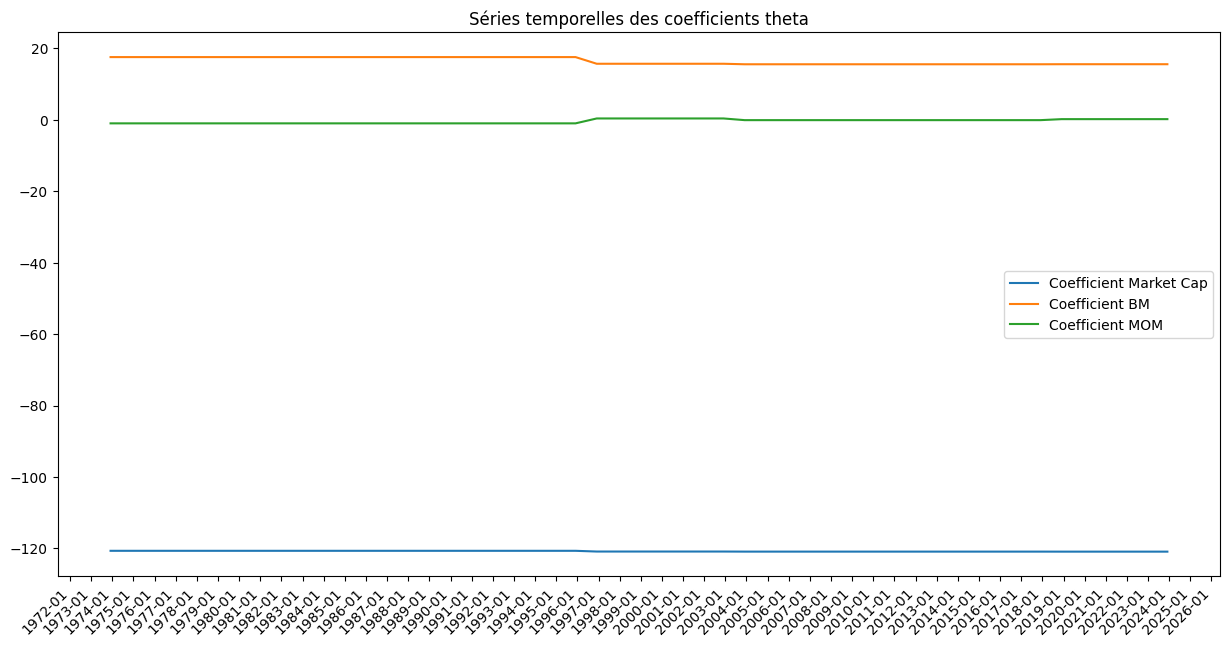

In [41]:
# Plot les séries temporelles pour chaque coefficient theta à travers T périodes de temps en utilisant la seconde méthode d'optimisation,
# avec les valeurs initiales des coefficients optimaux thetas estimés à partir de la période de temps précédente.
time_series_optimal_theta_second_method = plot_theta_series(optimal_thetas_second_method)
time_series_optimal_theta_second_method

### Calcul des poids de portefeuilles optimaux

In [23]:
opt_weights_monthly_second_method      = calculate_optimized_weights_monthly(mkt_weights, MC_standardized, BM_standardized, MOM_standardized, optimal_thetas_second_method)
opt_weights_monthly_second_method

1,Agric,Food,Soda,Beer,Smoke,Toys,Fun,Books,Hshld,Clths,...,Boxes,Trans,Whlsl,Rtail,Meals,Banks,Insur,RlEst,Fin,Other
1974-01-01,0.022629,0.027216,0.009210,0.025020,0.022531,0.020247,0.018872,0.023584,0.017834,0.021857,...,0.012796,0.022853,0.024995,0.019169,0.018078,0.019031,0.025444,0.018189,0.020404,0.017097
1974-02-01,0.022559,0.027117,0.009344,0.025150,0.022548,0.019935,0.018852,0.023761,0.018115,0.021799,...,0.012716,0.022809,0.024974,0.019141,0.018080,0.019037,0.025516,0.018051,0.020413,0.017087
1974-03-01,0.022455,0.027073,0.009422,0.025180,0.022574,0.019973,0.018797,0.023823,0.018352,0.021754,...,0.012613,0.022807,0.024880,0.019111,0.018067,0.019058,0.025553,0.018069,0.020410,0.017091
1974-04-01,0.022444,0.027048,0.009508,0.025135,0.022558,0.019825,0.018752,0.023608,0.018338,0.021702,...,0.012737,0.022767,0.024771,0.019050,0.017890,0.019030,0.025549,0.018012,0.020429,0.017039
1974-05-01,0.022373,0.027000,0.009540,0.025054,0.022402,0.020032,0.018649,0.023607,0.018525,0.021602,...,0.013059,0.022621,0.024608,0.018932,0.017777,0.019010,0.025498,0.018053,0.020496,0.016926
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2023-09-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2023-10-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.802032,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2023-11-01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.728371,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [24]:
optimized_port_returns, market_port_returns  =  calculate_portfolio_returns(opt_weights_monthly_second_method, mkt_weights, returns)

In [25]:
market_port_returns

,Portfolio Monthly Return
1974-01-01,0.000387
1974-02-01,-0.022024
1974-03-01,-0.045404
1974-04-01,-0.039492
1974-05-01,-0.022076
...,...
2023-08-01,-0.048094
2023-09-01,-0.026172
2023-10-01,0.093104
2023-11-01,0.051857


In [26]:
optimized_port_returns

,Portfolio Monthly Return
1974-01-01,0.008192
1974-02-01,-0.014377
1974-03-01,-0.048785
1974-04-01,-0.049562
1974-05-01,-0.029368
...,...
2023-08-01,-0.061900
2023-09-01,-0.020500
2023-10-01,0.080049
2023-11-01,0.109250


In [27]:
# 1) Calculer le rendement annuel moyen annualisé, la volatilité moyenne annualisée et le ratio de Sharpe pour le portefeuille optimisé et le portefeuille de marché
Sharpe_ratio_df                       = annualized_statistics_and_sharpe_ratios({
    'Optimized Portfolio': optimized_port_returns,
    'Market Portfolio': market_port_returns},
[('1974-01-01', '2023-12-01')],df_rf, is_decimal=True)
Sharpe_ratio_df

,,,Annualized Mean Return,Annualized Std Deviation,Sharpe Ratio
Strategy,Start Date,End Date,,,
Optimized Portfolio,1974-01-01,2023-12-01,16.7593,21.6510,0.6234
Market Portfolio,1974-01-01,2023-12-01,12.8762,15.8929,0.6049


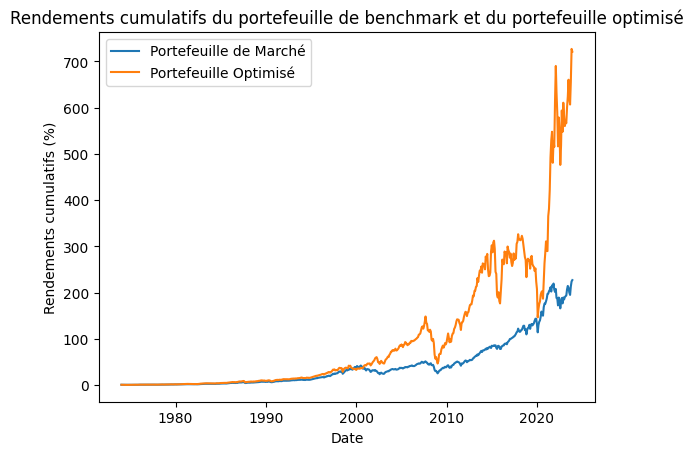

In [28]:
# 2) Plot les rendements cumulatifs pour les deux stratégies de portefeuilles (Optimized Portfolio et Market Portfolio),
# en utilisant les rendements mensuels calculés pour chaque stratégie.
strategies = [ 'Portefeuille de Marché', 'Portefeuille Optimisé']

plot_cumulative_returns_partC({
    'Portefeuille Optimisé': optimized_port_returns,
    'Portefeuille de Marché': market_port_returns
}, strategies)